In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## Load the data

In [19]:
# Clusters
clusters = pd.read_csv('data/processed/clusters_with_stats.csv')
clusters.head()

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,"AATTTA,AATTCT,AATTCA,AACTTA,AAATCC,AATATG,AATA..."
1,1,0.229000,NaN,ATCCGC
2,2,0.123416,0.014622,"ACCTAC,ACCTCC,ACATCC,ACATCA,ACATAC,AAATCA,ATAT..."
3,3,0.052767,0.008386,"CGTTCC,CGTCCC,CGTCAC"
4,4,0.104843,0.013261,"CCGAAA,CCGAAT,CCGTGA,CTGCCT,CCGGAC,CAAGTC,CCGG..."


In [20]:
# uASPIre
uaspire = pd.read_csv('data/raw/uASPIre_RBS_300k_r1.csv', sep='\t', usecols=['RBS', 'IFP480', 'total_reads'])

# Get the number of records
print(f'Originally {len(uaspire)} rows')

# Remove rows with total_reads < 50
uaspire = uaspire[uaspire['total_reads'] >= 1000].reset_index(drop=True)
print(f'After removing records with low number of reads {len(uaspire)} rows')

uaspire.head()

Originally 303503 rows
After removing records with low number of reads 25444 rows


,RBS,IFP480,total_reads
0,TAAGGATACTTACGCAC,0.62508,27829
1,ACTCTGGATGTAATGTG,0.15903,25038
2,ATCATCGCAAGCTGCGT,0.03045,24443
3,TGAAAGCGGGGTTCCTA,0.45974,21946
4,TTTAGAGGAACGAACAT,0.76043,18985


## Locate the core in the uASPIre dataset

### Transform the clusters dataset so we have core sequence and associated cluster and mean

In [21]:
# Create new dataframe, when one column is the core sequence (splitted SEQ_unique) and the others are the cluster and mean expression
clusters_core = (
    clusters
    .assign(SEQ_unique=clusters['SEQ_unique'].str.split(','))
    .explode('SEQ_unique')
    .reset_index(drop=True)
)

clusters_core.head()

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,AATTTA
1,0,0.129612,0.017409,AATTCT
2,0,0.129612,0.017409,AATTCA
3,0,0.129612,0.017409,AACTTA
4,0,0.129612,0.017409,AAATCC


### For each RBS in the uaspire dataset, find the strongest core

In [22]:
def find_best_rbs_core(rbs_sequence, core_df):
    """
    For a given RBS sequence, tries trimming 5–9 nt from the 3' end,
    extracts the preceding 6 nt each time, and looks them up in core_df.
    Returns the (core, cluster, expression) with the highest REL_EXPR_mean.
    """
    candidates = []
    for trim in range(5, 10):              # trim = 5,6,7,8,9
        if len(rbs_sequence) >= trim + 6:
            core = rbs_sequence[-trim-6:-trim]
            # look up matching cores in core_df
            match = core_df[core_df['SEQ_unique'] == core]
            if not match.empty:
                # if there are multiple rows per core (should not happen); take them all
                for _, row in match.iterrows():
                    candidates.append({
                        'core': core,
                        'cluster': row['CLUSTER_'],
                        'expr': row['CORE REL EXPR_mean']
                    })
    if not candidates:
        return pd.Series({'matched_core': None, 'cluster': None})

    # pick the one with maximal expression
    best = max(candidates, key=lambda x: x['expr'])
    return pd.Series({'matched_core': best['core'], 'cluster': best['cluster'], 'best_expr': best['expr']})

# Process every row in the uaspire dataframe
uaspire[['matched_core', 'cluster', 'best_expr']] = uaspire['RBS'].apply(find_best_rbs_core, core_df=clusters_core)

uaspire.head()

,RBS,IFP480,total_reads,matched_core,cluster,best_expr
0,TAAGGATACTTACGCAC,0.62508,27829,AGGATA,186,0.944783
1,ACTCTGGATGTAATGTG,0.15903,25038,TGGATG,184,0.626600
2,ATCATCGCAAGCTGCGT,0.03045,24443,GCAAGC,23,0.173730
3,TGAAAGCGGGGTTCCTA,0.45974,21946,GCGGGG,315,0.894928
4,TTTAGAGGAACGAACAT,0.76043,18985,AGGAAC,176,0.919315


## Evaluation

### Clusters vs IFP480

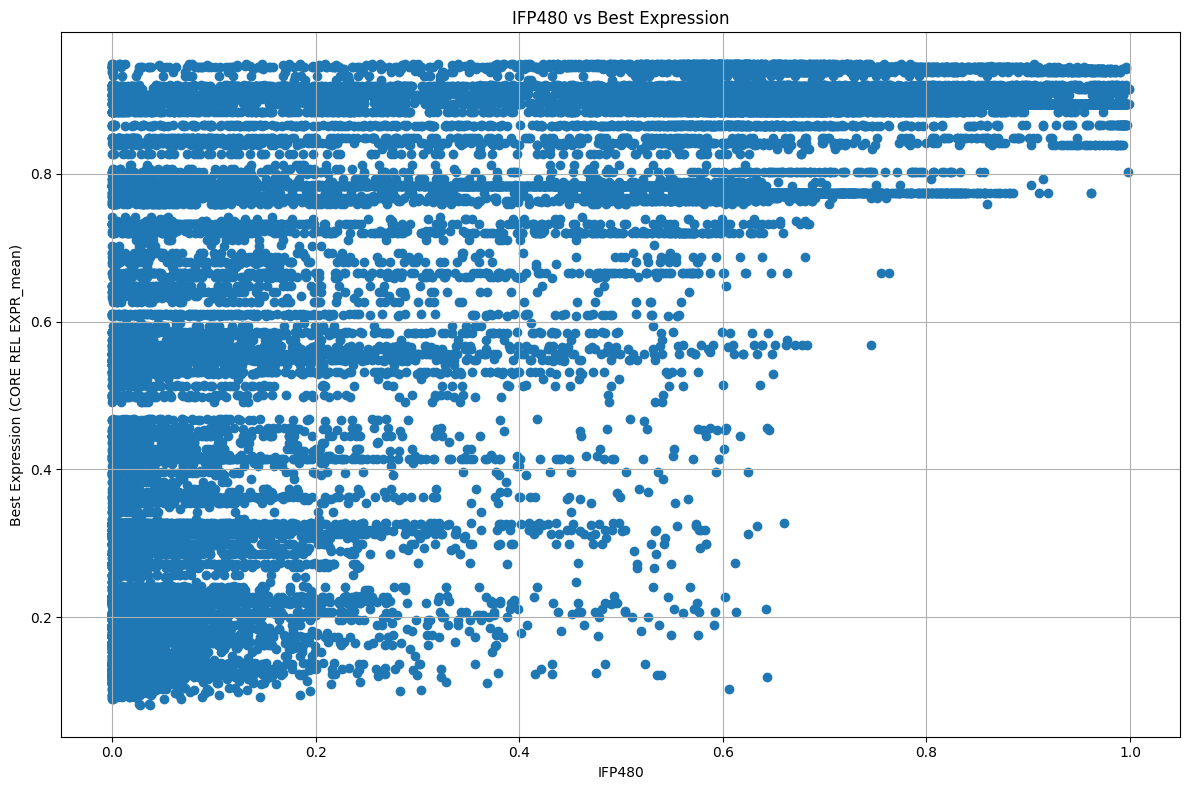

In [23]:
# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(uaspire['IFP480'], uaspire['best_expr'])
plt.xlabel('IFP480')
plt.ylabel('Best Expression (CORE REL EXPR_mean)')
plt.title('IFP480 vs Best Expression')
plt.grid(True)
plt.tight_layout()
plt.show()

## Clusters VS Aggregated IFP480

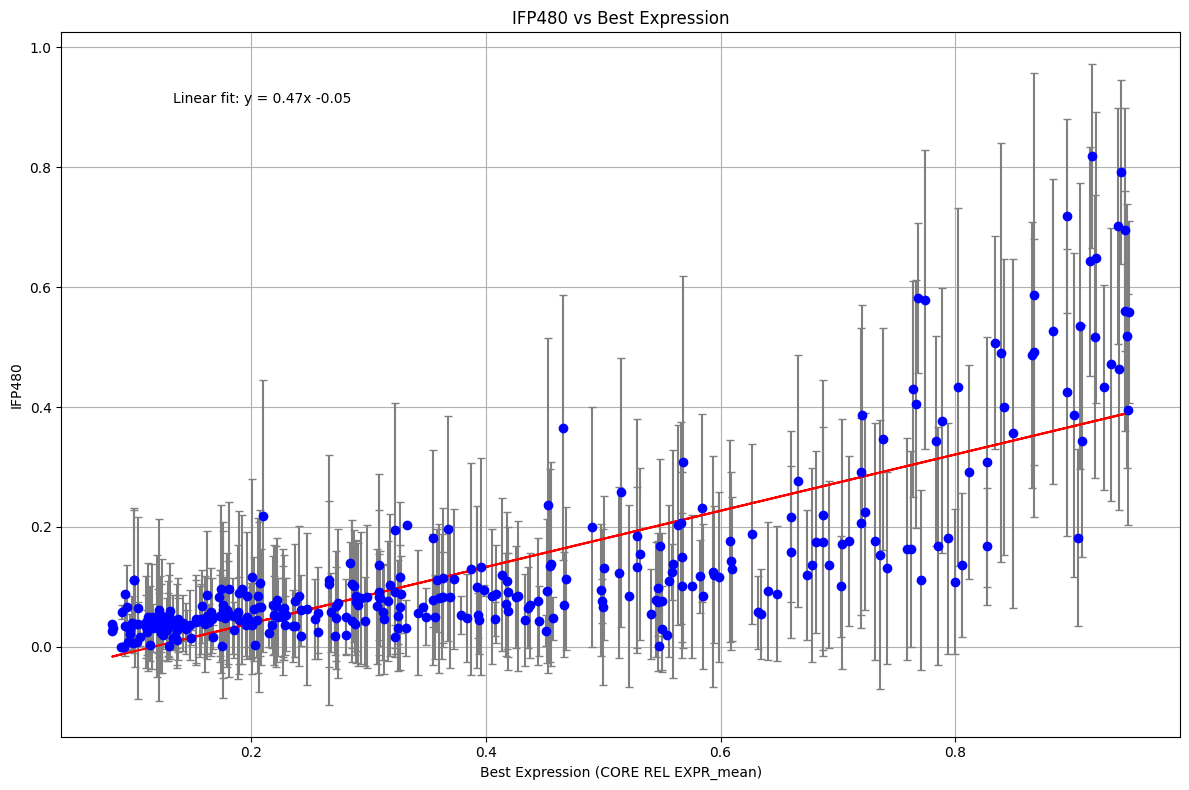

In [33]:
# From the uaspire dataframe, get the mean IFP480 value and standard deviation per cluster (and the cluster best expression)
aggregated_uaspire = (
    uaspire
    .groupby('cluster')
    .agg({'IFP480': ['mean', 'std'], 'best_expr': 'mean'})
    .reset_index()
)

# Try the linear fit and get the line equation
slope, intercept, r_value, p_value, std_err = stats.linregress(aggregated_uaspire['best_expr']['mean'], aggregated_uaspire['IFP480']['mean'])

# Scatter plot with error bars of the mean IFP480 and core expression
plt.figure(figsize=(12, 8))
plt.errorbar(
    aggregated_uaspire['best_expr']['mean'],
    aggregated_uaspire['IFP480']['mean'],
    yerr=aggregated_uaspire['IFP480']['std'],
    fmt='o',                # draw circle markers only
    color='blue',           # sets marker edge & (if no facecolor override) face to blue
    markerfacecolor='blue', # explicitly fill markers blue
    markeredgecolor='blue', # explicitly set marker outline blue
    ecolor='grey',          # sets the error‐bars to grey
    capsize=3               # optional: little caps on the errorbars
)
# Plot the linear line
plt.plot(aggregated_uaspire['best_expr']['mean'], slope*aggregated_uaspire['best_expr']['mean'] + intercept, color='red')
# Add the labels, mainly include the line equation
plt.text(0.1, 0.9, f'Linear fit: y = {slope:.2f}x {intercept:.2f}', transform=plt.gca().transAxes)

plt.xlabel('Best Expression (CORE REL EXPR_mean)')
plt.ylabel('IFP480')
plt.title('IFP480 vs Best Expression')
plt.grid(True)
plt.tight_layout()
plt.show()